# Step 1: 清洗数据，转换数据格式

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd


In [20]:
dataPath = Path("D:\\projects\\2022-01 Graduation\\仿真振动信号数据")
files = [file for file in dataPath.iterdir() if "sum" not in file.name]
out_file = dataPath / "vibration_sum.xlsx"
writer = pd.ExcelWriter(out_file)

for file in files:
    with open(file, encoding='utf-8') as temp_f:
        col_count = [len(l.split(",")) for l in temp_f.readlines()]

    column_names = [i for i in range(max(col_count))]
    data = pd.read_csv(file, skip_blank_lines=True, error_bad_lines=False, names=column_names)
    labels = data.iloc[len(data) - 2, :]
    signals = data.iloc[len(data) - 1, :]
    time_series = []
    for label in labels:
        if "ppb" not in label: continue
        cur_time = label.split("t=")[-1]
        if len(time_series) == 0 or time_series[len(time_series) - 1] != cur_time:
            time_series.append(cur_time)
    signals_reformat = pd.DataFrame(columns=['x', 'y', 'z'], index=time_series)
    for i, signal in enumerate(signals):
        label = labels[i]
        cur_time = label.split("t=")[-1]
        if "ppb1" in label:
            signals_reformat.loc[cur_time, 'x'] = signal
        elif "ppb2" in label:
            signals_reformat.loc[cur_time, 'y'] = signal
        else:
            signals_reformat.loc[cur_time, 'z'] = signal

    signals_reformat.to_excel(writer, sheet_name=file.stem)

writer.save()
writer.close()

D:\Programming\Anaconda3\envs\py38-pt18\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


# Step 2: 读取数据，绘制图像

In [21]:
import numpy as np
import pandas as pd
from pylab import *
from palettable.colorbrewer.qualitative import Set2_7
import h5py
from pathlib import Path
from domainbed.lib import FFT
from scipy import signal
from scipy.interpolate import interp2d
import scipy.io as scio
import pywt

olors = Set2_7.mpl_colors

params = {
    'axes.labelsize': 8,
    'font.size': 8,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': False,
    'figure.figsize': [4.5, 4.5]
}
rcParams.update(params)
plt.style.use(['science', 'no-latex', 'cjk-sc-font'])

In [22]:
import numpy as np
from scipy.signal import wavelets


# 定义小波变换函数
def wavelet_denoising(signal, waveletname='db4', level=3):
    coeff = pywt.wavedec(signal, waveletname, level=level)
    coeff[-1:] = [pywt.threshold(i, value=np.std(i) * 0.25, mode="hard") for i in coeff[-1:]]
    denoised_signal = pywt.waverec(coeff, waveletname)
    return denoised_signal


In [23]:
dataPath = Path("D:\\ShareFiles")
file = dataPath / "vibration_sum.xlsx"

data = pd.read_excel(file, sheet_name=None)

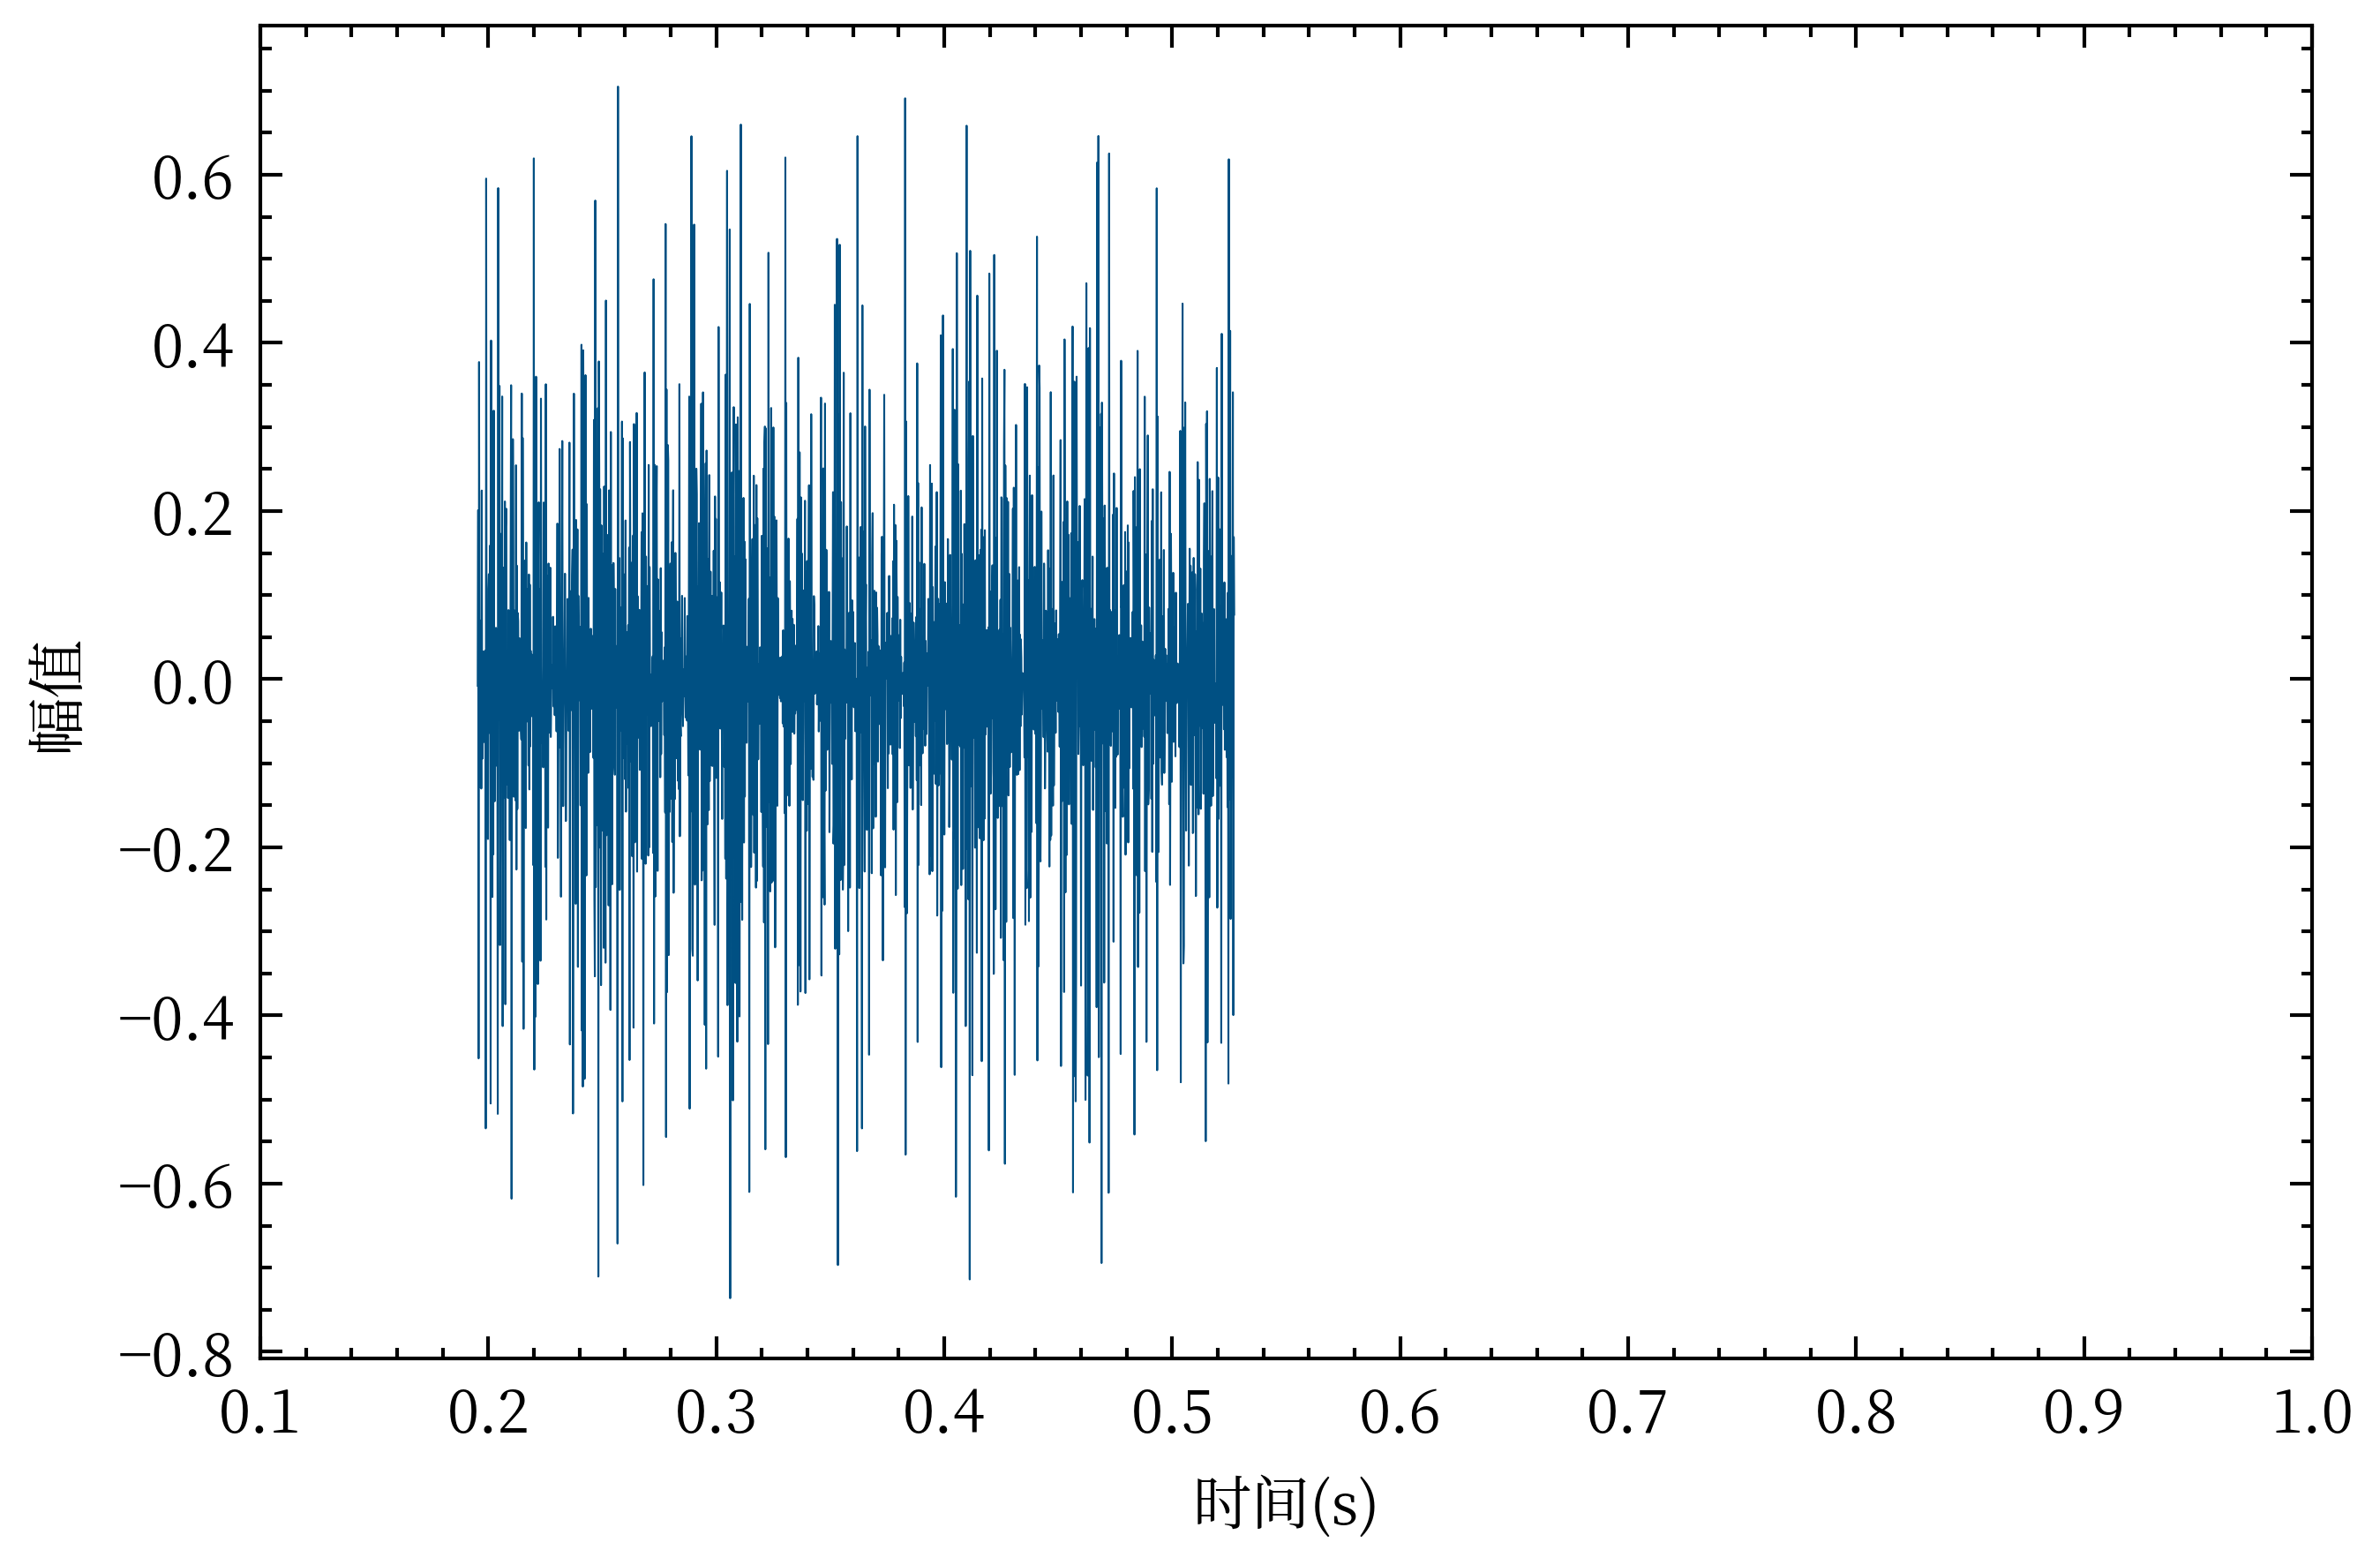

In [39]:
sheetName = 'normal_vibration'
sampling_frequency = 5120
signals = data[sheetName]
time = signals['Unnamed: 0'][1000:2700]
sig = signals['x'][1000:2700]
# sig = wavelet_denoising(sig)

# coeffs = pywt.wavedec(sig, 'db1', level=2)
# coeffs[-1] = pywt.threshold(coeffs[-1], np.std(coeffs[-1]))
# coeffs[-2] = pywt.threshold(coeffs[-2], np.std(coeffs[-2]))
# sig = pywt.waverec(coeffs, 'db1')

fig, ax = plt.subplots(1, 1, figsize=(6 / 1.2, 4 / 1.2), dpi=600)
ax.plot(time, sig[0:len(time)], color=(0, 80 / 255, 131 / 255), linewidth=0.25)
ax.set_xlabel('时间(s)')
ax.set_ylabel('幅值')
ax.set_xlim(0.1, 1)
# plt.savefig('figs/simulation_time_domain_normal.png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

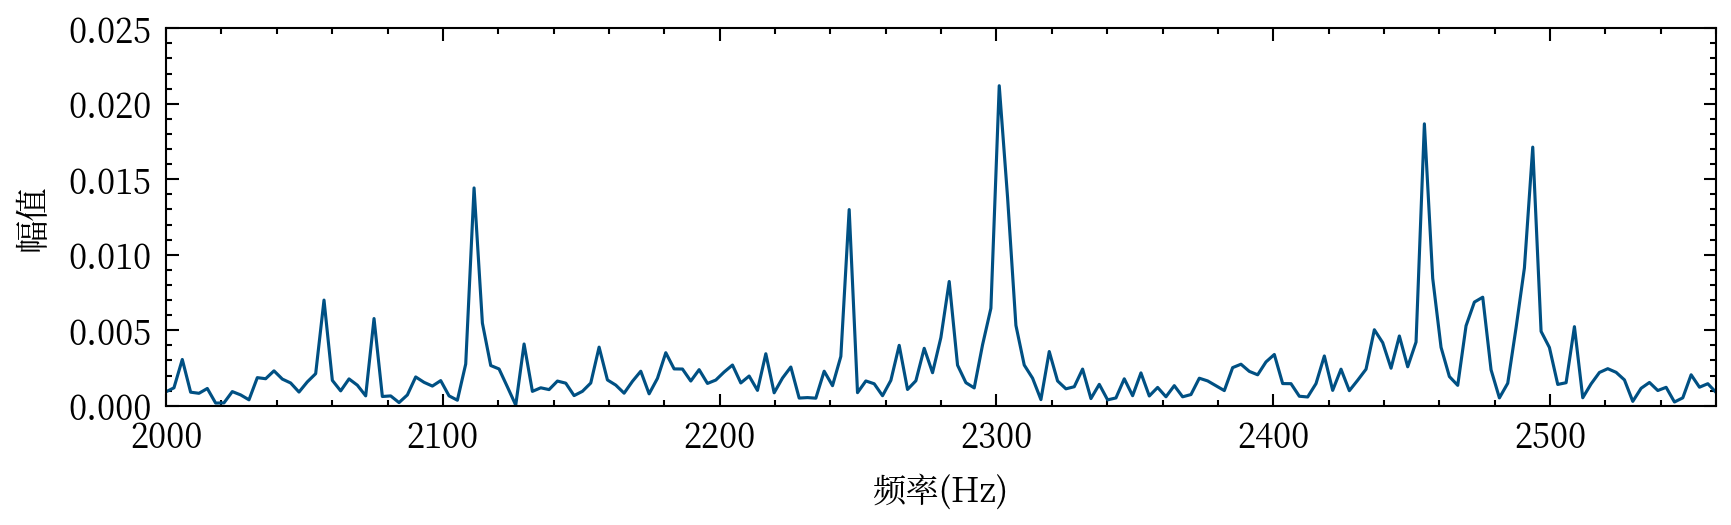

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(8 / 1.2, 2 / 1.2), dpi=300)
fre, amp = FFT.fft(sig, sampling_frequency)
ax.plot(fre, amp, color=(0, 80 / 255, 131 / 255), linewidth=0.75)
ax.set_xlabel('频率(Hz)')
ax.set_ylabel('幅值')
ax.set_xlim(2000, sampling_frequency // 2)
ax.set_ylim(0, 0.025)
plt.savefig('figs/simulation_frequency_domain_normal_2560.png', dpi=300, bbox_inches='tight', transparent=True)

# 包络谱分析

In [16]:
from scipy import signal
from scipy.signal import hilbert

# 定义信号
signal = np.sin(2 * np.pi * 100 * np.linspace(0, 1, 1000))

# 计算信号的包络谱
analytic_signal = hilbert(sig)
envelope = np.abs(analytic_signal)

# 绘制
ax.plot(envelope, color=(0, 80 / 255, 131 / 255), linewidth=0.25)
ax.set_xlabel('频率(Hz)')
ax.set_ylabel('幅值')
ax.set_xlim(0, sampling_frequency // 2)
plt.savefig('figs/simulation_frequency_domain_normal_spectrum_envelope.png', dpi=300, bbox_inches='tight',
            pad_inches=0, transparent=True)


<Figure size 252x189 with 0 Axes>

D:\Programming\Anaconda3\envs\py38-pt18\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


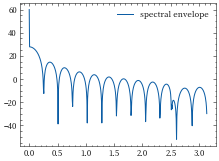

In [19]:
import numpy as np
from scipy.signal import hilbert, freqz
import matplotlib.pyplot as plt

# 定义信号
signal = np.sin(2 * np.pi * 100 * np.linspace(0, 1, 1000))

# 计算信号的频谱包络谱
analytic_signal = hilbert(signal)
envelope = np.abs(analytic_signal)

# 绘制频谱
f, H = freqz(envelope)

# 绘制结果
plt.plot(f, 20 * np.log10(H), label='spectral envelope')
plt.legend()

# 显示图像
plt.show()


In [47]:
import matplotlib.pyplot as plt
import pywt
import sys

# Data format:
# Raw data should be in a .txt file with two columns, separated by tabs:
#  - The first column should be a time-series index
#  - The second column should contain the data to be filtered

# Get data:
# file_object = open('./Biosignals.txt', 'r')
raw_data = sig
index = []
data = []
for i in range(len(raw_data) - 1):
    x, y = raw_data[i].split('\t')
    X = float(x)
    Y = float(y)
    index.append(X)
    data.append(Y)

# Create wavelet object and define parameters
w = pywt.Wavelet('sym4')
maxlev = pywt.dwt_max_level(len(data), w.dec_len)
# maxlev = 2 # Override if desired
print("maximum level is " + str(maxlev))
threshold = 0.04  # Threshold for filtering

# Decompose into wavelet components, to the level selected:
coeffs = pywt.wavedec(data, 'sym4', level=maxlev)

#cA = pywt.threshold(cA, threshold*max(cA))
plt.figure()
for i in range(1, len(coeffs)):
    plt.subplot(maxlev, 1, i)
    plt.plot(coeffs[i])
    coeffs[i] = pywt.threshold(coeffs[i], threshold * max(coeffs[i]))
    plt.plot(coeffs[i])

datarec = pywt.waverec(coeffs, 'sym4')

mintime = 1000
maxtime = mintime + 2000

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(index[mintime:maxtime], data[mintime:maxtime])
plt.xlabel('time (s)')
plt.ylabel('microvolts (uV)')
plt.title("Raw signal")
plt.subplot(2, 1, 2)
plt.plot(index[mintime:maxtime], datarec[mintime:maxtime])
plt.xlabel('time (s)')
plt.ylabel('microvolts (uV)')
plt.title("De-noised signal using wavelet techniques")

plt.tight_layout()
plt.show()

# fs = 500
# f, t, Sxx = signal.spectrogram(data, fs)
# plt.pcolormesh(t, f, Sxx)
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.ylim(0, 50)
# plt.show()

AttributeError: 'numpy.float64' object has no attribute 'split'